In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import SelectPercentile

In [3]:
# Googleドライブのマウント
from google.colab import drive
drive.mount('/content/drive')
'''
import sys
sys.path.append('/content/drive/My Drive/MachineLearning/feature-engineering')

from zipfile import ZipFile
# ZIPファイルをアップロード
uploaded_zip_path = "/content/drive/MyDrive/MachineLearning/feature-engineering/data/IoT Network Intrusion Dataset.csv.zip"  # アップロードするZIPファイルのパスを指定

# ZIPファイルの解凍
with ZipFile(uploaded_zip_path, 'r') as zip_ref:
    zip_ref.extractall("data")
'''
%cd /content/drive/My Drive/MachineLearning
data = pd.read_csv('feature-engineering/data/data2-iot-100.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/MachineLearning


In [5]:
# データ数を表示
num_columns = len(data.columns)
print(data.columns)
print("data shape is: {}".format(data.shape))

Index(['Flow_ID', 'Src_IP', 'Src_Port', 'Dst_IP', 'Dst_Port', 'Protocol',
       'Timestamp', 'Flow_Duration', 'Tot_Fwd_Pkts', 'Tot_Bwd_Pkts',
       'TotLen_Fwd_Pkts', 'TotLen_Bwd_Pkts', 'Fwd_Pkt_Len_Max',
       'Fwd_Pkt_Len_Min', 'Fwd_Pkt_Len_Mean', 'Fwd_Pkt_Len_Std',
       'Bwd_Pkt_Len_Max', 'Bwd_Pkt_Len_Min', 'Bwd_Pkt_Len_Mean',
       'Bwd_Pkt_Len_Std', 'Flow_Byts/s', 'Flow_Pkts/s', 'Flow_IAT_Mean',
       'Flow_IAT_Std', 'Flow_IAT_Max', 'Flow_IAT_Min', 'Fwd_IAT_Tot',
       'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Max', 'Fwd_IAT_Min',
       'Bwd_IAT_Tot', 'Bwd_IAT_Mean', 'Bwd_IAT_Std', 'Bwd_IAT_Max',
       'Bwd_IAT_Min', 'Fwd_PSH_Flags', 'Bwd_PSH_Flags', 'Fwd_URG_Flags',
       'Bwd_URG_Flags', 'Fwd_Header_Len', 'Bwd_Header_Len', 'Fwd_Pkts/s',
       'Bwd_Pkts/s', 'Pkt_Len_Min', 'Pkt_Len_Max', 'Pkt_Len_Mean',
       'Pkt_Len_Std', 'Pkt_Len_Var', 'FIN_Flag_Cnt', 'SYN_Flag_Cnt',
       'RST_Flag_Cnt', 'PSH_Flag_Cnt', 'ACK_Flag_Cnt', 'URG_Flag_Cnt',
       'CWE_Flag_Count', 'ECE_

In [6]:
# Botnetの種類が載っている特徴量を分離する
data = data.drop(columns=['Cat', 'Sub_Cat'])

In [7]:
# 文字列データのカラム名を検出
string_columns = data.select_dtypes(include=['object']).columns.tolist()

print(string_columns)

# ワンホットエンコーディングを行う
df = pd.get_dummies(data, columns=string_columns)

['Flow_ID', 'Src_IP', 'Dst_IP', 'Timestamp', 'Label']


In [8]:
# 変換後のデータ数を表示
num_columns = len(df.columns)
print(df.columns)
print(f"Number of columns: {num_columns}")

Index(['Src_Port', 'Dst_Port', 'Protocol', 'Flow_Duration', 'Tot_Fwd_Pkts',
       'Tot_Bwd_Pkts', 'TotLen_Fwd_Pkts', 'TotLen_Bwd_Pkts', 'Fwd_Pkt_Len_Max',
       'Fwd_Pkt_Len_Min',
       ...
       'Timestamp_25/07/2019 03:26:18 AM', 'Timestamp_26/05/2019 10:06:28 PM',
       'Timestamp_26/05/2019 10:06:50 PM', 'Timestamp_26/05/2019 10:11:06 PM',
       'Timestamp_26/05/2019 10:11:08 PM', 'Timestamp_26/05/2019 10:11:14 PM',
       'Timestamp_26/05/2019 10:20:36 PM', 'Timestamp_31/05/2019 03:16:07 AM',
       'Label_Anomaly', 'Label_Normal'],
      dtype='object', length=269)
Number of columns: 269


In [9]:
# ターゲット変数の設定(Anomalyが１、Normalが0)
X = df.drop(columns=['Label_Anomaly', 'Label_Normal'])  #　labelを除外して特徴量として使用
y = df['Label_Anomaly']  # labelをターゲット変数として使用

# データをトレーニングセットとテストセットに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
# ロジスティック回帰モデルを作成
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# テストセットを使って予測
y_pred = model.predict(X_test)

# 予測結果の評価
print("線形モデルの正確度:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

線形モデルの正確度: 0.8333333333333334
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.96      0.86      0.91        29

    accuracy                           0.83        30
   macro avg       0.48      0.43      0.45        30
weighted avg       0.93      0.83      0.88        30



In [11]:
# 決定木で学習
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_test)
print(f"決定木の正確度: {accuracy_score(y_test, y_pred_dt)*100:.2f}%")

決定木の正確度: 96.67%


In [12]:
# ランダムフォレストで学習
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print(f"ランダムフォレストの正確度: {accuracy_score(y_test, y_pred_rf)*100:.2f}%")

ランダムフォレストの正確度: 96.67%


X_train.shape: (69, 267)
X_train_selected.shape: (69, 133)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True False False False False  True  True
  True  True  True False  True  True False  True False False False False
  True  True  True  True  True  True  True  True  True False  True False
 False  True False False False  True  True  True  True False False False
 False False False  True  True  True  True False  True  True False  True
 False  True  True False False False False  True  True  True False False
 False False  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True False False False  True  True  True
  True False  True  True  True False  True  True  True  True  True False
 False False  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True False  True False  True False
  True False False False  True  True  True  True  True  True  Tru

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 32  33  34  35  45  47  48  50  51  52  57  58  59  60  61  62  67  70
  72  82  83  84  85  96 102 103 104 109 113 119 120 121 127 139 141 143
 145 147 161 169 170 171 172 175 177 178 183 185 186 188 191 194 198 199
 209 219 224 228 230 234 238 241 242 244 246 247 255 257 259 260 265] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


([], [])

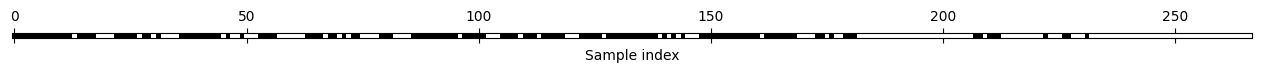

In [13]:
# 単変量測定を行う
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)

# 訓練セットを変換
X_train_selected = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

# 結果の可視化--黒が真、白が偽
mask = select.get_support()
print(mask)
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

In [14]:
# 線形回帰の比較
X_test_selected = select.transform(X_test)

#　全ての特徴量を用いる
model.fit(X_train, y_train)
print("Score with all  features: {:.3f}".format(model.score(X_test, y_test)))

# 選択された特徴量だけを用いる
model.fit(X_train_selected, y_train)
print("Score with only selected features: {:.3f}".format(model.score(X_test_selected, y_test)))

Score with all  features: 0.833
Score with only selected features: 0.833


X_train.shape: (69, 267)
X_train_l1.shape: (69, 267)
Test score_l1: 0.833


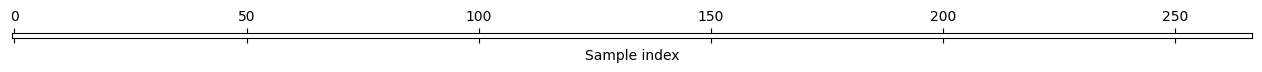

In [15]:
# モデルベース特徴量選択
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median")

select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

mask = select.get_support()
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

X_test_l1 = select.transform(X_test)
score_l1 = model.fit(X_train_l1, y_train).score(X_test_l1, y_test)
print("Test score_l1: {:.3f}".format(score_l1))

このまま実行すると、ほとんどの特徴量の重要度が0であるため、特徴量が削除されずに残ってしまう。
そのため、閾値を手動で設定する。


X_train.shape: (69, 267)
X_train_l1.shape: (69, 36)
Test score: 0.833


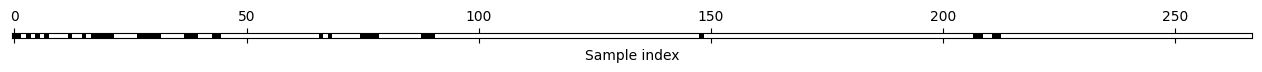

In [16]:
# 閾値を0.01に設定し、もう一度検証
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold = 0.01)

select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

mask = select.get_support()
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

X_test_l1 = select.transform(X_test)
score_l1 = model.fit(X_train_l1, y_train).score(X_test_l1, y_test)
print("Test score: {:.3f}".format(score_l1))


Test score: 0.833
Test score_rfe: 0.967


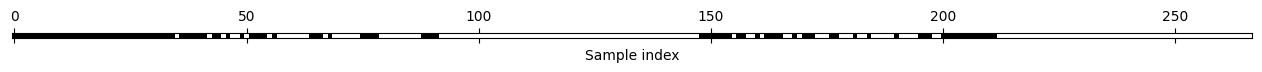

In [17]:
# 反復特徴量選択

from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
             n_features_to_select=100)

select.fit(X_train, y_train)
# visualize the selected features:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

score = LogisticRegression(max_iter=1000).fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print("Test score: {:.3f}".format(score))
print("Test score_rfe: {:.3f}".format(select.score(X_test, y_test)))